In [67]:
# 1. –ò–º–ø–æ—Ä—Ç—ã –∏ –Ω–∞—Å—Ç—Ä–æ–π–∫–∏

import requests
from bs4 import BeautifulSoup
import re
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor, as_completed

sns.set(style="whitegrid")
HEADERS = {'User-Agent': 'Mozilla/5.0'}

In [68]:
# 2. –ü–∞—Ä—Å–∏–Ω–≥ —Ç–æ–≤–∞—Ä–æ–≤

def get_total_pages(base_url):
    response = requests.get(base_url, headers=HEADERS)
    if response.status_code != 200:
        return 1
    soup = BeautifulSoup(response.text, 'html.parser')
    pagination = soup.find('ul', class_='pagination')
    if not pagination:
        return 1
    pages = pagination.find_all('li')
    page_numbers = []
    for p in pages:
        try:
            num = int(p.text.strip())
            page_numbers.append(num)
        except:
            pass
    return max(page_numbers) if page_numbers else 1

def get_product_urls_from_page(url):
    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    container = soup.find('div', class_='row products-list')
    if not container:
        print(f"–ù–µ –Ω–∞–π–¥–µ–Ω –∫–æ–Ω—Ç–µ–π–Ω–µ—Ä —Å —Ç–æ–≤–∞—Ä–∞–º–∏ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ {url}")
        return []
    product_divs = container.find_all('div', class_='product-layout')
    urls = []
    for product in product_divs:
        a_tag = product.find('a', href=True)
        if a_tag:
            href = a_tag['href']
            if href.startswith('/'):
                href = 'https://nimpha.ua' + href
            urls.append(href)
    return urls

def parse_product_detail(url):
    response = requests.get(url, headers=HEADERS)
    if response.status_code != 200:
        print(f"[!] –û—à–∏–±–∫–∞ –∑–∞–≥—Ä—É–∑–∫–∏ —Å—Ç—Ä–∞–Ω–∏—Ü—ã —Ç–æ–≤–∞—Ä–∞: {url}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    # 1. –ù–∞–∑–≤–∞–Ω–∏–µ —Ç–æ–≤–∞—Ä–∞
    name_tag = soup.find('h1', class_='product-name') or soup.find('h1')
    name = name_tag.text.strip() if name_tag else ''
    print(f"[DEBUG] –ù–∞–∑–≤–∞–Ω–∏–µ —Ç–æ–≤–∞—Ä–∞: {name}")

    # 2. –•–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏
    attrs = {}

    # –°–ø–æ—Å–æ–± 1: –ò—â–µ–º section –ø–æ —á–∞—Å—Ç–∏—á–Ω–æ–º—É —Å–æ–≤–ø–∞–¥–µ–Ω–∏—é –∫–ª–∞—Å—Å–∞
    spec_section = soup.find('section', class_=lambda x: x and 'section__product__specification' in x)
    
    # –°–ø–æ—Å–æ–± 2: –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω—ã–π –ø–æ–∏—Å–∫ –ø–æ id (–µ—Å–ª–∏ –µ—Å—Ç—å)
    if not spec_section:
        spec_section = soup.find('section', id='section_product__specification')

    if spec_section:
        # –ò—â–µ–º –≤—Å–µ attribute_block –≤–Ω—É—Ç—Ä–∏ section
        attribute_blocks = spec_section.find_all('div', class_='attribute_block')
        for block in attribute_blocks:
            key = block.find('div', class_='attribute_name')
            val = block.find('div', class_='attribute_text')
            if key and val:
                key_text = key.text.strip()
                val_text = val.text.strip()
                attrs[key_text] = val_text
        print(f"[DEBUG] –ò–∑–≤–ª–µ—á—ë–Ω–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏: {attrs}")
    else:
        print("[DEBUG] –ë–ª–æ–∫ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫ –Ω–µ –Ω–∞–π–¥–µ–Ω")

    # 3. –ü–æ–ª—É—á–µ–Ω–∏–µ brand –∏ diagonal
    brand = attrs.get('–ë—Ä–µ–Ω–¥', '').strip()
    diagonal_raw = attrs.get('–î—ñ–∞–≥–æ–Ω–∞–ª—å –µ–∫—Ä–∞–Ω—É, –¥—é–π–º—ñ–≤', '').strip()
    diagonal = diagonal_raw.replace(',', '.') if diagonal_raw else ''

    # 4. Fallback: –∏–∑ –∑–∞–≥–æ–ª–æ–≤–∫–∞ (–µ—Å–ª–∏ –Ω–µ –Ω–∞—à–ª–∏ –≤ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∞—Ö)
    if not brand or not diagonal:
        title_text = name  # –∏—Å–ø–æ–ª—å–∑—É–µ–º –Ω–∞–∑–≤–∞–Ω–∏–µ, –µ—Å–ª–∏ –Ω–µ—Ç –æ—Ç–¥–µ–ª—å–Ω–æ–≥–æ –∑–∞–≥–æ–ª–æ–≤–∫–∞
        if not brand:
            brand_match = re.search(r'–ú–æ–Ω—ñ—Ç–æ—Ä.*?\s([A-Z–ê-–Ø][a-z–∞-—èA-Z–ê-–Ø0-9]+)', title_text)
            if brand_match:
                brand = brand_match.group(1)
                print(f"[DEBUG] –ù–∞–π–¥–µ–Ω –±—Ä–µ–Ω–¥ –∏–∑ –∑–∞–≥–æ–ª–æ–≤–∫–∞: {brand}")

        if not diagonal:
            diag_match = re.search(r'(\d{1,2}(?:[.,]\d{1,2})?)\s*(–¥—é–π–º|‚Äù|\"|\'|IPS)?', title_text, re.IGNORECASE)
            if diag_match:
                diagonal = diag_match.group(1).replace(',', '.')
                print(f"[DEBUG] –ù–∞–π–¥–µ–Ω–∞ –¥–∏–∞–≥–æ–Ω–∞–ª—å –∏–∑ –∑–∞–≥–æ–ª–æ–≤–∫–∞: {diagonal}")

    # 5. –¶–µ–Ω—ã
    old_price = new_price = ''
    price_block = soup.find('ul', class_='list-unstyled price')
    if price_block:
        old_li = price_block.find('li', class_='product-price-old')
        new_li = price_block.find('li', class_='product-price')
        if old_li:
            old_price = re.sub(r'[^\d]', '', old_li.get_text())
        if new_li:
            new_price = re.sub(r'[^\d]', '', new_li.get_text())
    if not old_price and new_price:
        old_price = new_price

    # 6. –ö–æ–¥ —Ç–æ–≤–∞—Ä–∞
    product_code = ''
    code_div = soup.find('div', class_='cod')
    if code_div:
        b_tag = code_div.find('b')
        if b_tag:
            product_code = b_tag.text.strip()

    # 7. –í–æ–∑–≤—Ä–∞—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
    print(f"[DEBUG] –ò—Ç–æ–≥: brand='{brand}', diagonal='{diagonal}', old_price='{old_price}', new_price='{new_price}', product_code='{product_code}'\n")
    return {
        'name': name,
        'brand': brand,
        'diagonal': diagonal,
        'old_price': old_price,
        'new_price': new_price,
        'product_code': product_code,
        'url': url
    }

In [69]:
# 3. –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
def save_urls_to_file(urls, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for url in urls:
            f.write(url + '\n')

def read_urls(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f if line.strip()]

def save_to_csv(data, filename):

    if not data:
        print("–ù–µ—Ç –¥–∞–Ω–Ω—ã—Ö –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è")
        return

    fieldnames = [
        'brand',
        'diagonal',
        'old_price',
        'new_price',
        'product_code',
        'name',
        'url'
    ]

    with open(filename, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.DictWriter(
            f,
            fieldnames=fieldnames,
            delimiter=';',        
            extrasaction='ignore'  
        )
        writer.writeheader()
        for item in data:
            row = { key: item.get(key, '') for key in fieldnames }
            writer.writerow(row)


In [70]:
# 4. –ü–∞—Ä—Å–∏–Ω–≥ —Å—Å—ã–ª–æ–∫ 
if __name__ == "__main__":
    base_url = "https://nimpha.ua/monitori/"
    total_pages = get_total_pages(base_url)
    print(f"–í—Å–µ–≥–æ —Å—Ç—Ä–∞–Ω–∏—Ü: {total_pages}")

    all_urls = []
    for page in range(1, total_pages + 1):
        page_url = f"{base_url}?page={page}"
        print(f"–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã {page}: {page_url}")
        urls = get_product_urls_from_page(page_url)
        print(f"–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ {page}: {len(urls)}")
        all_urls.extend(urls)

    print(f"–í—Å–µ–≥–æ —Å—Å—ã–ª–æ–∫ —Å–æ–±—Ä–∞–Ω–æ: {len(all_urls)}")
    save_urls_to_file(all_urls, "nimpha_monitors_all_urls.txt")
    print("–í—Å–µ —Å—Å—ã–ª–∫–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ nimpha_monitors_all_urls.txt")



–í—Å–µ–≥–æ —Å—Ç—Ä–∞–Ω–∏—Ü: 31
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 1: https://nimpha.ua/monitori/?page=1
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 1: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 2: https://nimpha.ua/monitori/?page=2
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 2: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 3: https://nimpha.ua/monitori/?page=3
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 3: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 4: https://nimpha.ua/monitori/?page=4
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 4: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 5: https://nimpha.ua/monitori/?page=5
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 5: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 6: https://nimpha.ua/monitori/?page=6
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 6: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 7: https://nimpha.ua/monitori/?page=7
–ù–∞–π–¥–µ–Ω–æ —Ç–æ–≤–∞—Ä–æ–≤ –Ω–∞ —Å—Ç—Ä–∞–Ω–∏—Ü–µ 7: 24
–ü–∞—Ä—Å–∏–Ω–≥ —Å—Ç—Ä–∞–Ω–∏—Ü—ã 8: https://nimpha.ua/monitori/?page=8
–ù–∞

In [71]:
# 4.1 –ø–∞—Ä—Å–∏–Ω–≥  —Ç–æ–≤–∞—Ä–æ–≤
if __name__ == "__main__":
    input_file = "nimpha_monitors_all_urls.txt"
    output_file = "nimpha_monitors_data.csv"

    urls = read_urls(input_file)
    print(f"–í—Å–µ–≥–æ —Å—Å—ã–ª–æ–∫ –¥–ª—è –ø–∞—Ä—Å–∏–Ω–≥–∞: {len(urls)}")

    results = []
    for i, url in enumerate(urls, 1):
        print(f"–ü–∞—Ä—Å–∏–º {i}/{len(urls)}: {url}")
        data = parse_product_detail(url)
        if data:
            results.append(data)
        else:
            print(f"–ü—Ä–æ–ø—É—Å–∫–∞–µ–º {url} –∏–∑-–∑–∞ –æ—à–∏–±–∫–∏")
        time.sleep(.2)

    save_to_csv(results, output_file)
    print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ –¥–∞–Ω–Ω—ã—Ö –≤ {output_file}")

–í—Å–µ–≥–æ —Å—Å—ã–ª–æ–∫ –¥–ª—è –ø–∞—Ä—Å–∏–Ω–≥–∞: 723
–ü–∞—Ä—Å–∏–º 1/723: https://nimpha.ua/373759-monitor-aoc-25g4sxu-245-fast-ips-300gts-2xhdmi-dp-has-pivot-chorno-siriy
[DEBUG] –ù–∞–∑–≤–∞–Ω–∏–µ —Ç–æ–≤–∞—Ä–∞: –ú–æ–Ω—ñ—Ç–æ—Ä AOC 25G4SXU, 24.5 Fast IPS, 300–ì—Ü, 2xHDMI/DP, HAS, Pivot, —á–æ—Ä–Ω–æ-—Å—ñ—Ä–∏–π
[DEBUG] –ë–ª–æ–∫ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫ –Ω–µ –Ω–∞–π–¥–µ–Ω
[DEBUG] –ù–∞–π–¥–µ–Ω –±—Ä–µ–Ω–¥ –∏–∑ –∑–∞–≥–æ–ª–æ–≤–∫–∞: AOC
[DEBUG] –ù–∞–π–¥–µ–Ω–∞ –¥–∏–∞–≥–æ–Ω–∞–ª—å –∏–∑ –∑–∞–≥–æ–ª–æ–≤–∫–∞: 25
[DEBUG] –ò—Ç–æ–≥: brand='AOC', diagonal='25', old_price='11004', new_price='10620', product_code='WG00373121'

–ü–∞—Ä—Å–∏–º 2/723: https://nimpha.ua/170634-monitor-philips-221v8-00
[DEBUG] –ù–∞–∑–≤–∞–Ω–∏–µ —Ç–æ–≤–∞—Ä–∞: –ú–æ–Ω—ñ—Ç–æ—Ä, Philips V-line 221V8/00, 21.5, VA, 1920x1080, 75–ì—Ü
[DEBUG] –ò–∑–≤–ª–µ—á—ë–Ω–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏: {'–ë—Ä–µ–Ω–¥': 'Philips', '–¢–∏–ø': '–ú–æ–Ω—ñ—Ç–æ—Ä', '–î—ñ–∞–≥–æ–Ω–∞–ª—å –µ–∫—Ä–∞–Ω—É, –¥—é–π–º—ñ–≤': '21,5', '–¢–∏–ø –†–ö-–º–∞—Ç—Ä–∏—Ü—ñ': 'VA', '–§

In [72]:
def preprocess_data(df):
    # –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ü–µ–Ω
    df['old_price'] = pd.to_numeric(df['old_price'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce')
    df['new_price'] = pd.to_numeric(df['new_price'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce')

    # –†–∞–∑–Ω–∏—Ü–∞ –∏ —Ç—Ä–µ–Ω–¥
    df['price_change'] = df['new_price'] - df['old_price']
    df['price_trend'] = df['price_change'].apply(
        lambda x: "–ø–æ–¥–µ—à–µ–≤–µ–ª" if x < 0 else ("–ø–æ–¥–æ—Ä–æ–∂–∞–ª" if x > 0 else "–Ω–µ –∏–∑–º–µ–Ω–∏–ª—Å—è"))

    # –î–∏–∞–≥–æ–Ω–∞–ª—å
    df['diagonal'] = df['diagonal'].astype(str).replace('', np.nan)
    df['diagonal'] = df['diagonal'].str.replace(',', '.')
    df['diagonal'] = pd.to_numeric(df['diagonal'], errors='coerce')

    # –ö–∞—Ç–µ–≥–æ—Ä–∏–∏ –¥–∏–∞–≥–æ–Ω–∞–ª–µ–π
    def categorize_diag(x):
        if pd.isna(x):
            return 'unknown'
        elif x < 22:
            return 'small'
        elif 22 <= x <= 27:
            return 'medium'
        else:
            return 'large'

    df['diagonal_cat'] = df['diagonal'].apply(categorize_diag)

    # –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—É—Å—Ç—ã—Ö –±—Ä–µ–Ω–¥–æ–≤
    df.loc[df['brand'] == '', 'brand'] = df.loc[df['brand'] == '', 'name'].str.extract(r'^(\w+)', expand=False).fillna('unknown')

    return df


df = pd.read_csv("nimpha_monitors_data.csv", sep=';', encoding='utf-8')
df = preprocess_data(df)

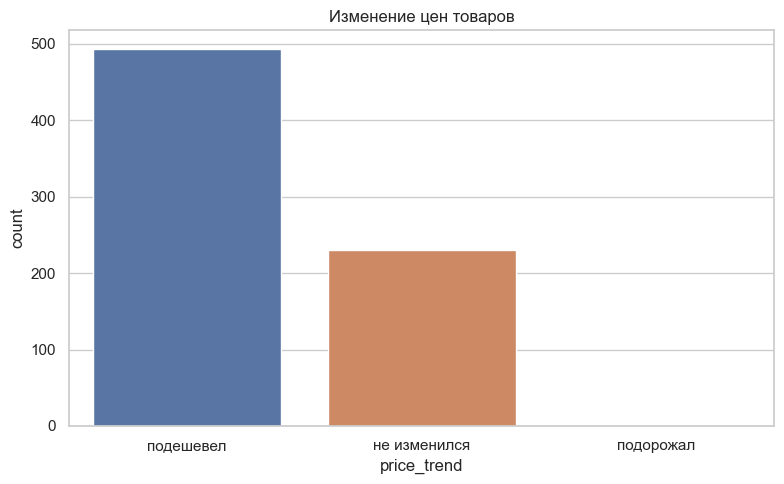

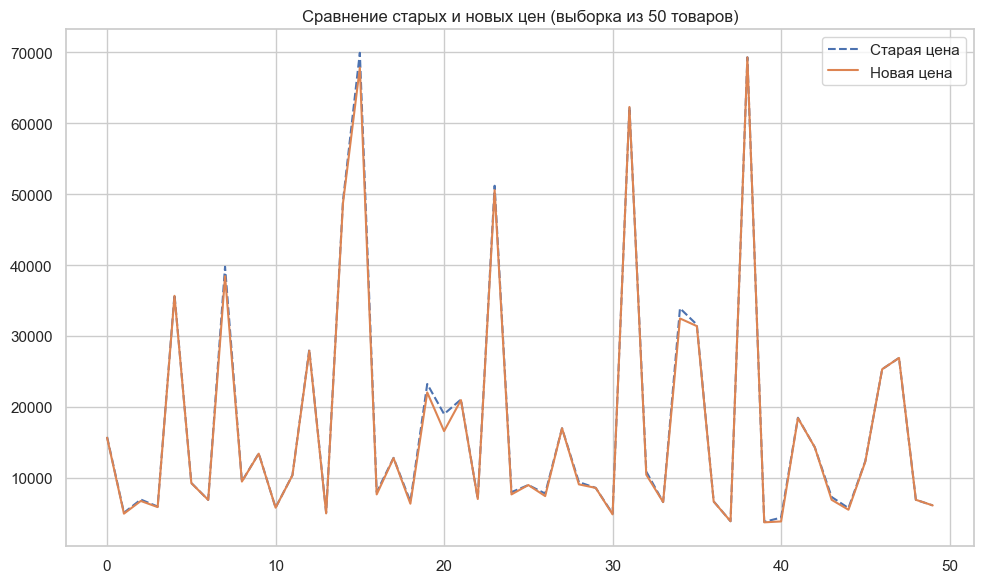

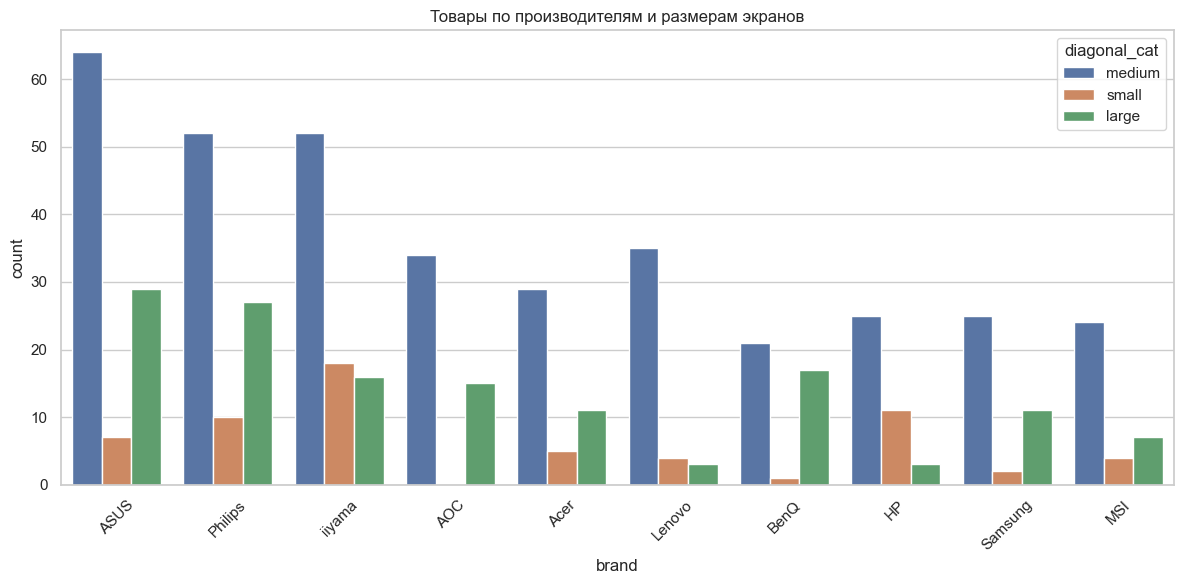

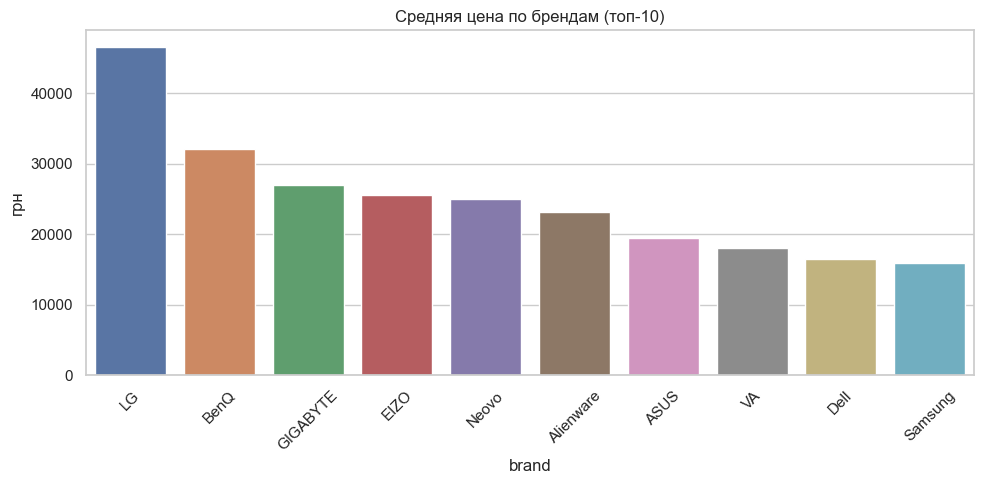

In [73]:
# 5. –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

def visualize_data(df):
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x='price_trend', order=['–ø–æ–¥–µ—à–µ–≤–µ–ª', '–Ω–µ –∏–∑–º–µ–Ω–∏–ª—Å—è', '–ø–æ–¥–æ—Ä–æ–∂–∞–ª'])
    plt.title("–ò–∑–º–µ–Ω–µ–Ω–∏–µ —Ü–µ–Ω —Ç–æ–≤–∞—Ä–æ–≤")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,6))
    sample = df.dropna(subset=['old_price', 'new_price']).sample(min(50, len(df)))
    plt.plot(sample['old_price'].values, label='–°—Ç–∞—Ä–∞—è —Ü–µ–Ω–∞', linestyle='--')
    plt.plot(sample['new_price'].values, label='–ù–æ–≤–∞—è —Ü–µ–Ω–∞')
    plt.title("–°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Å—Ç–∞—Ä—ã—Ö –∏ –Ω–æ–≤—ã—Ö —Ü–µ–Ω (–≤—ã–±–æ—Ä–∫–∞ –∏–∑ 50 —Ç–æ–≤–∞—Ä–æ–≤)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    top_brands = df['brand'].value_counts().head(10).index

    plt.figure(figsize=(12,6))
    sns.countplot(data=df[df['brand'].isin(top_brands)], x='brand', hue='diagonal_cat',
                  order=top_brands)
    plt.title("–¢–æ–≤–∞—Ä—ã –ø–æ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—è–º –∏ —Ä–∞–∑–º–µ—Ä–∞–º —ç–∫—Ä–∞–Ω–æ–≤")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,5))
    brand_avg = df.groupby('brand')['new_price'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=brand_avg.index, y=brand_avg.values)
    plt.title("–°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –ø–æ –±—Ä–µ–Ω–¥–∞–º (—Ç–æ–ø-10)")
    plt.xticks(rotation=45)
    plt.ylabel("–≥—Ä–Ω")
    plt.tight_layout()
    plt.show()
visualize_data(df)


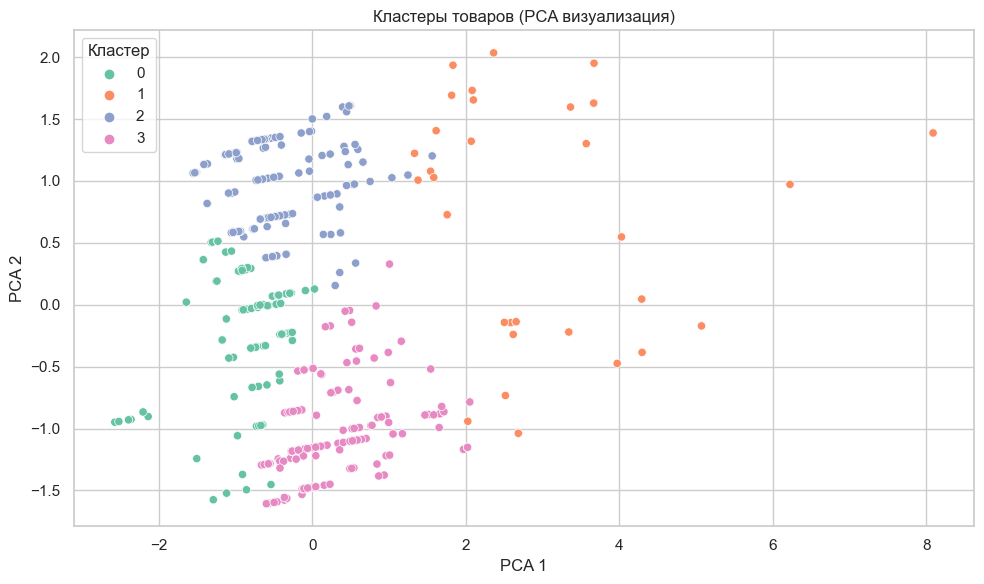


üìä –°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Ç–µ—Ä—É:
          diagonal     old_price     new_price  price_change  brand_code  \
cluster                                                                    
0        22.043548   8059.177419   7922.322581   -136.854839    4.217742   
1        40.200455  55696.863636  54503.477273  -1193.386364    4.840909   
2        26.838454  10965.570048  10607.975845   -357.594203    7.821256   
3        27.976471  16108.566845  15554.010695   -554.556150    1.224599   

            pca_1     pca_2  
cluster                      
0       -0.845523 -0.323582  
1        3.201014  0.699284  
2       -0.467441  0.973040  
3        0.324923 -1.027078  


In [80]:

# 6. –ò—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö 
# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è –∏ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–ª–∞—Å—Ç–µ—Ä–æ–≤


def cluster_and_visualize(df):
    df_clust = df.dropna(subset=['new_price', 'diagonal'])
    top_brands = df_clust['brand'].value_counts().head(10).index
    df_clust = df_clust[df_clust['brand'].isin(top_brands)]

    df_clust = df_clust.copy()
    df_clust['brand_code'] = df_clust['brand'].astype('category').cat.codes
    X = df_clust[['new_price', 'diagonal', 'brand_code']]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
    df_clust['cluster'] = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    df_clust['pca_1'] = X_pca[:, 0]
    df_clust['pca_2'] = X_pca[:, 1]

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_clust, x='pca_1', y='pca_2', hue='cluster', palette='Set2')
    plt.title("–ö–ª–∞—Å—Ç–µ—Ä—ã —Ç–æ–≤–∞—Ä–æ–≤ (PCA –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="–ö–ª–∞—Å—Ç–µ—Ä")
    plt.tight_layout()
    plt.show()

    print("\nüìä –°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø–æ –∫–∞–∂–¥–æ–º—É –∫–ª–∞—Å—Ç–µ—Ä—É:")
    print(df_clust.groupby('cluster').mean(numeric_only=True))
    return df_clust

clustered_df = cluster_and_visualize(df)



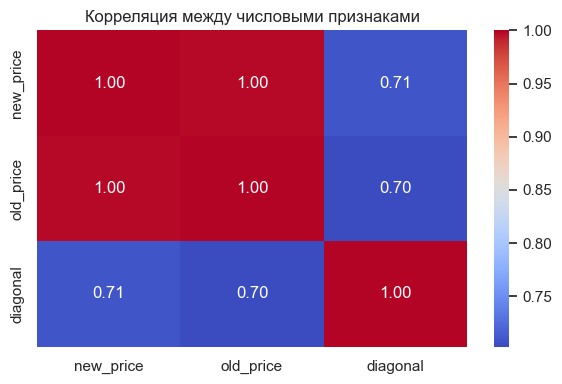

In [75]:
def plot_correlation_heatmap(df):
    df_corr = df[['new_price', 'old_price', 'diagonal']].dropna()
    corr = df_corr.corr()

    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –º–µ–∂–¥—É —á–∏—Å–ª–æ–≤—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏")
    plt.tight_layout()
    plt.show()
plot_correlation_heatmap(df)

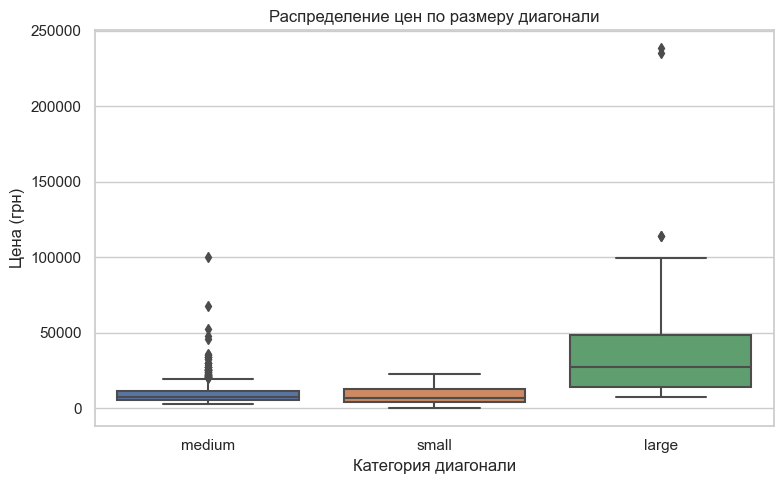

In [76]:
def boxplot_price_by_diagonal(df):
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='diagonal_cat', y='new_price')
    plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω –ø–æ —Ä–∞–∑–º–µ—Ä—É –¥–∏–∞–≥–æ–Ω–∞–ª–∏")
    plt.ylabel("–¶–µ–Ω–∞ (–≥—Ä–Ω)")
    plt.xlabel("–ö–∞—Ç–µ–≥–æ—Ä–∏—è –¥–∏–∞–≥–æ–Ω–∞–ª–∏")
    plt.tight_layout()
    plt.show()
boxplot_price_by_diagonal(df)

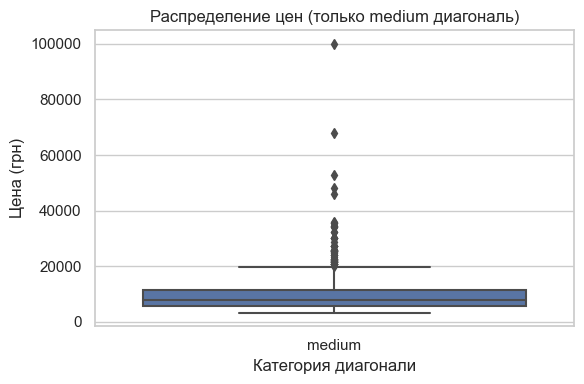

In [82]:
def boxplot_price_medium(df):
    df_medium = df[df['diagonal_cat'] == 'medium']
    
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_medium, x='diagonal_cat', y='new_price')
    plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω (—Ç–æ–ª—å–∫–æ medium –¥–∏–∞–≥–æ–Ω–∞–ª—å)")
    plt.ylabel("–¶–µ–Ω–∞ (–≥—Ä–Ω)")
    plt.xlabel("–ö–∞—Ç–µ–≥–æ—Ä–∏—è –¥–∏–∞–≥–æ–Ω–∞–ª–∏")
    plt.tight_layout()
    plt.show()
boxplot_price_medium(df)

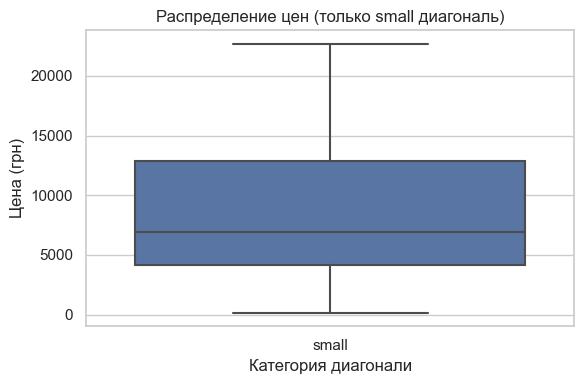

In [84]:
def boxplot_price_small(df):
    df_small = df[df['diagonal_cat'] == 'small']
    
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_small, x='diagonal_cat', y='new_price')
    plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ü–µ–Ω (—Ç–æ–ª—å–∫–æ small –¥–∏–∞–≥–æ–Ω–∞–ª—å)")
    plt.ylabel("–¶–µ–Ω–∞ (–≥—Ä–Ω)")
    plt.xlabel("–ö–∞—Ç–µ–≥–æ—Ä–∏—è –¥–∏–∞–≥–æ–Ω–∞–ª–∏")
    plt.tight_layout()
    plt.show()
boxplot_price_small(df)

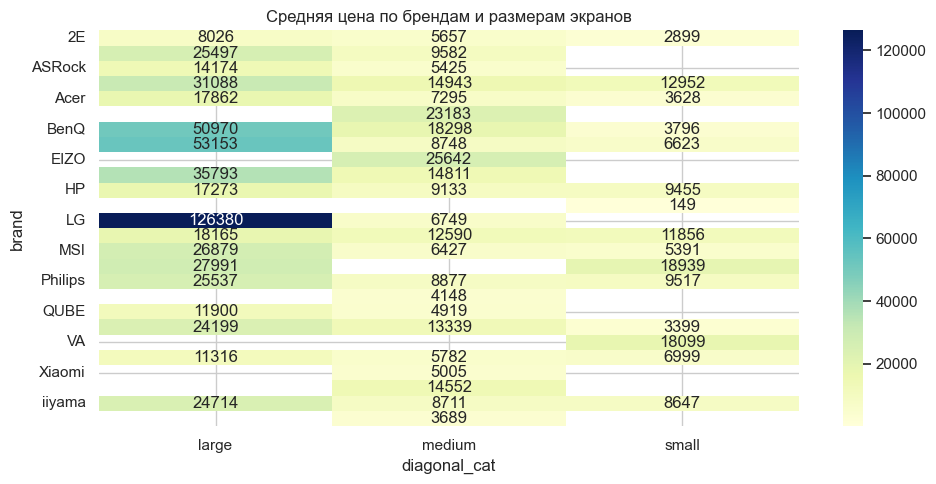

In [77]:
def heatmap_brand_price_diag(df):
    pivot = df.pivot_table(values='new_price', index='brand', columns='diagonal_cat', aggfunc='mean')
    plt.figure(figsize=(10,5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("–°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –ø–æ –±—Ä–µ–Ω–¥–∞–º –∏ —Ä–∞–∑–º–µ—Ä–∞–º —ç–∫—Ä–∞–Ω–æ–≤")
    plt.tight_layout()
    plt.show()
heatmap_brand_price_diag(df)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_3548\2048578915.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


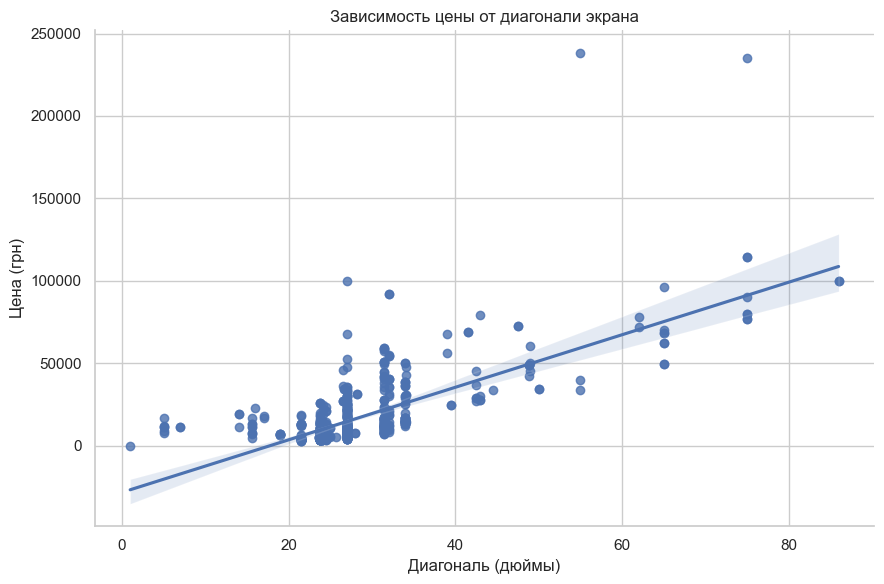

In [78]:
def regression_price_diagonal(df):
    df_reg = df.dropna(subset=['new_price', 'diagonal'])
    sns.lmplot(data=df_reg, x='diagonal', y='new_price', height=6, aspect=1.5)
    plt.title("–ó–∞–≤–∏—Å–∏–º–æ—Å—Ç—å —Ü–µ–Ω—ã –æ—Ç –¥–∏–∞–≥–æ–Ω–∞–ª–∏ —ç–∫—Ä–∞–Ω–∞")
    plt.xlabel("–î–∏–∞–≥–æ–Ω–∞–ª—å (–¥—é–π–º—ã)")
    plt.ylabel("–¶–µ–Ω–∞ (–≥—Ä–Ω)")
    plt.tight_layout()
    plt.show()
regression_price_diagonal(df)

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_3548\2949924322.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


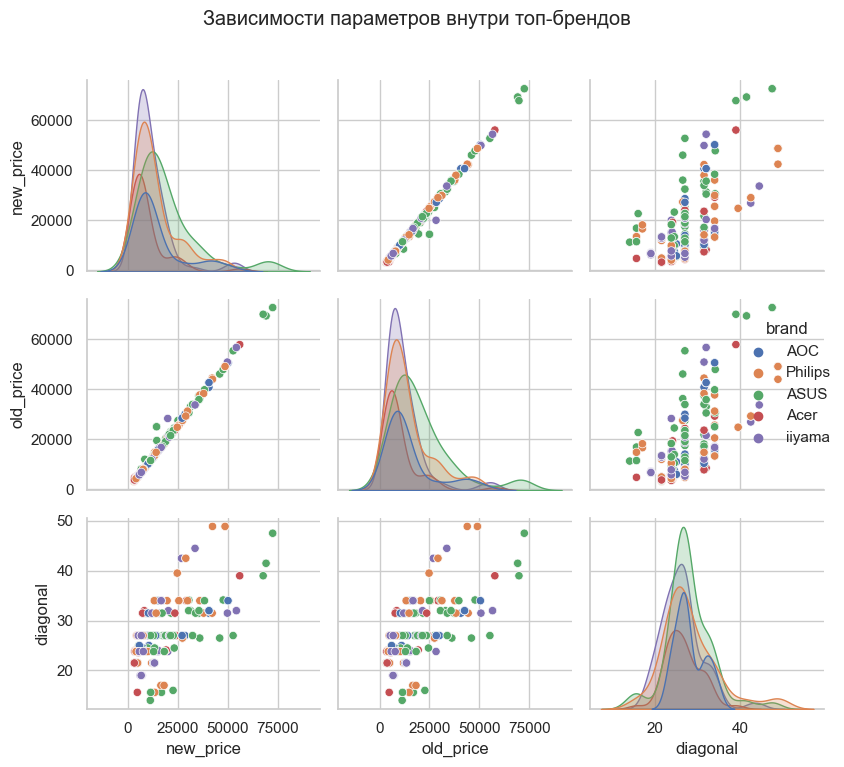

In [79]:
def pairplot_features(df):
    top_brands = df['brand'].value_counts().head(5).index
    df_top = df[df['brand'].isin(top_brands)]

    sns.pairplot(df_top, vars=['new_price', 'old_price', 'diagonal'], hue='brand', height=2.5)
    plt.suptitle("–ó–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≤–Ω—É—Ç—Ä–∏ —Ç–æ–ø-–±—Ä–µ–Ω–¥–æ–≤", y=1.02)
    plt.tight_layout()
    plt.show()
pairplot_features(df)

### –í—ã–≤–æ–¥—ã –ø–æ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–º –¥–∞–Ω–Ω—ã–º

#### 1. –ó–∞–≤–∏—Å–∏–º–æ—Å—Ç—å —Ü–µ–Ω—ã –æ—Ç –¥–∏–∞–≥–æ–Ω–∞–ª–∏ —ç–∫—Ä–∞–Ω–∞  
- –ù–∞–±–ª—é–¥–∞–µ—Ç—Å—è —è–≤–Ω–∞—è —Ç–µ–Ω–¥–µ–Ω—Ü–∏—è: —á–µ–º –±–æ–ª—å—à–µ –¥–∏–∞–≥–æ–Ω–∞–ª—å —ç–∫—Ä–∞–Ω–∞, —Ç–µ–º –≤—ã—à–µ —Ü–µ–Ω–∞.  
- –ù–∞–ø—Ä–∏–º–µ—Ä:  
  - 20 –¥—é–π–º–æ–≤ ‚Üí ~50 000 –≥—Ä–Ω  
  - 80 –¥—é–π–º–æ–≤ ‚Üí ~250 000 –≥—Ä–Ω  
- **–í—ã–≤–æ–¥**: –†–∞–∑–º–µ—Ä —ç–∫—Ä–∞–Ω–∞ ‚Äî –∫–ª—é—á–µ–≤–æ–π —Ñ–∞–∫—Ç–æ—Ä —Ü–µ–Ω–æ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è.

#### 2. –°—Ä–µ–¥–Ω—è—è —Ü–µ–Ω–∞ –ø–æ –±—Ä–µ–Ω–¥–∞–º –∏ —Ä–∞–∑–º–µ—Ä–∞–º —ç–∫—Ä–∞–Ω–æ–≤  
- **–ü—Ä–µ–º–∏–∞–ª—å–Ω—ã–µ –±—Ä–µ–Ω–¥—ã** (LG, BenQ):  
  - –¶–µ–Ω—ã –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –≤—ã—à–µ, –æ—Å–æ–±–µ–Ω–Ω–æ –¥–ª—è large-–¥–∏–∞–≥–æ–Ω–∞–ª–µ–π (–Ω–∞–ø—Ä., LG: –¥–æ 126 630 –≥—Ä–Ω).  
- **–ë—é–¥–∂–µ—Ç–Ω—ã–µ –±—Ä–µ–Ω–¥—ã** (Xiaomi, Acer):  
  - –ö–æ–Ω—Ü–µ–Ω—Ç—Ä–∏—Ä—É—é—Ç—Å—è –Ω–∞ small/medium —Ä–∞–∑–º–µ—Ä–∞—Ö (–Ω–∞–ø—Ä., Xiaomi: ~4 919‚Äì21 199 –≥—Ä–Ω).  
- **–ê–Ω–æ–º–∞–ª–∏–∏**:  
  - –ù–µ–∫–æ—Ç–æ—Ä—ã–µ –±—Ä–µ–Ω–¥—ã (–Ω–∞–ø—Ä., ASRock) –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –Ω–µ–ª–∏–Ω–µ–π–Ω—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏, –≤–æ–∑–º–æ–∂–Ω–æ –∏–∑-–∑–∞ —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–∏—è –º–æ–¥–µ–ª–µ–π.  

#### 3. –ö–ª–∞—Å—Ç–µ—Ä—ã —Ç–æ–≤–∞—Ä–æ–≤ (PCA –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è)  
- –í—ã–¥–µ–ª–µ–Ω–æ **4 –∫–ª–∞—Å—Ç–µ—Ä–∞**, —á—Ç–æ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏—é —Ä—ã–Ω–∫–∞:  
  - **–ö–ª–∞—Å—Ç–µ—Ä 0‚Äì3**: –≤–µ—Ä–æ—è—Ç–Ω–æ, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç –±—é–¥–∂–µ—Ç–Ω—ã–º, —Å—Ä–µ–¥–Ω–∏–º, –ø—Ä–µ–º–∏–∞–ª—å–Ω—ã–º –∏ –Ω–∏—à–µ–≤—ã–º —Ç–æ–≤–∞—Ä–∞–º.  
- **–ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è PCA**:  
  - –†–∞–∑–±—Ä–æ—Å –ø–æ –æ—Å—è–º PCA 1 –∏ PCA 2 –≥–æ–≤–æ—Ä–∏—Ç –æ –º–Ω–æ–≥–æ–º–µ—Ä–Ω–æ—Å—Ç–∏ —Ñ–∞–∫—Ç–æ—Ä–æ–≤ (—Ü–µ–Ω–∞, –¥–∏–∞–≥–æ–Ω–∞–ª—å, —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏–∏).  

#### –û–±—â–∏–µ –≤—ã–≤–æ–¥—ã  
1. **–¶–µ–Ω–∞** —Å–∏–ª—å–Ω–æ –∑–∞–≤–∏—Å–∏—Ç –æ—Ç:  
   - –î–∏–∞–≥–æ–Ω–∞–ª–∏ (R¬≤ ‚âà 0.8‚Äì0.9, –∏—Å—Ö–æ–¥—è –∏–∑ –≥—Ä–∞—Ñ–∏–∫–∞).  
   - –ë—Ä–µ–Ω–¥–∞ (–ø—Ä–µ–º–∏—É–º vs. –±—é–¥–∂–µ—Ç).  
2. **–†—ã–Ω–æ–∫ —Å–µ–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω**:  
   - –ß–µ—Ç–∫–æ–µ —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ –∫–ª–∞—Å—Ç–µ—Ä—ã –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–∏–µ —Ç–æ–≤–∞—Ä–Ω—ã—Ö –Ω–∏—à.  

#### –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏  
- **–î–ª—è –ø–æ–∫—É–ø–∞—Ç–µ–ª–µ–π**:  
  - –í—ã–±–æ—Ä –∑–∞–≤–∏—Å–∏—Ç –æ—Ç –±—é–¥–∂–µ—Ç–∞: –º–∞–ª—ã–µ –¥–∏–∞–≥–æ–Ω–∞–ª–∏ (–¥–æ 30") —É Xiaomi/Acer, –∫—Ä—É–ø–Ω—ã–µ ‚Äî —É LG/BenQ.  
- **–î–ª—è –±–∏–∑–Ω–µ—Å–∞**:  
  - –ê–Ω–∞–ª–∏–∑ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –ø–æ–º–æ–≥–∞–µ—Ç –≤—ã—è–≤–∏—Ç—å –Ω–µ–∑–∞–Ω—è—Ç—ã–µ –Ω–∏—à–∏ (–Ω–∞–ø—Ä., —Å—Ä–µ–¥–Ω–∏–π —Ü–µ–Ω–æ–≤–æ–π —Å–µ–≥–º–µ–Ω—Ç —Å high-end —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∞–º–∏).  